# Project - Lung and Colon Cancer Detection using CNNs

Before we start with our analysis, we need to load all necessary imports.

In [9]:
import os
import pickle
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.applications import ResNet50, MobileNetV2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Additionally, we need to initialize the necessary directories (used for storing models and stats) in case they don't exist.

In [10]:
dirs = ['./models', './stats', './images']

for dir in dirs:
    if not os.path.exists(dir): 
        os.makedirs(dir)

Before we start training our models, we need to load the dataset.

In [11]:
# data_folder = '/kaggle/input/neumre/data'
data_folder = './data'

file_paths = []
labels = []

class_folders = os.listdir(data_folder)
for class_folder in class_folders:
    class_folder_path = os.path.join(data_folder, class_folder)
    class_files = os.listdir(class_folder_path)

    for file in class_files:
        file_path = os.path.join(class_folder_path, file)
        
        file_paths.append(file_path)
        
        if class_folder == 'colon_aca':
            labels.append('Colon Adenocarcinoma')
        elif class_folder == 'colon_n':
            labels.append('Colon Benign Tissue')
        elif class_folder == 'lung_aca':
            labels.append('Lung Adenocarcinoma')
        elif class_folder == 'lung_n':
            labels.append('Lung Benign Tissue')
        elif class_folder == 'lung_scc':
            labels.append('Lung Squamous Cell Carcinoma')

file_series = pd.Series(file_paths, name='filepath')
label_series = pd.Series(labels, name='label')
data = pd.concat([file_series, label_series], axis=1)

print(data.describe())

                                filepath                 label
count                              25000                 25000
unique                             25000                     5
top     ./data/lung_scc/lungscc3298.jpeg  Colon Adenocarcinoma
freq                                   1                  5000


To verify that we loaded the dataset properly, we can visualize a few of the images.

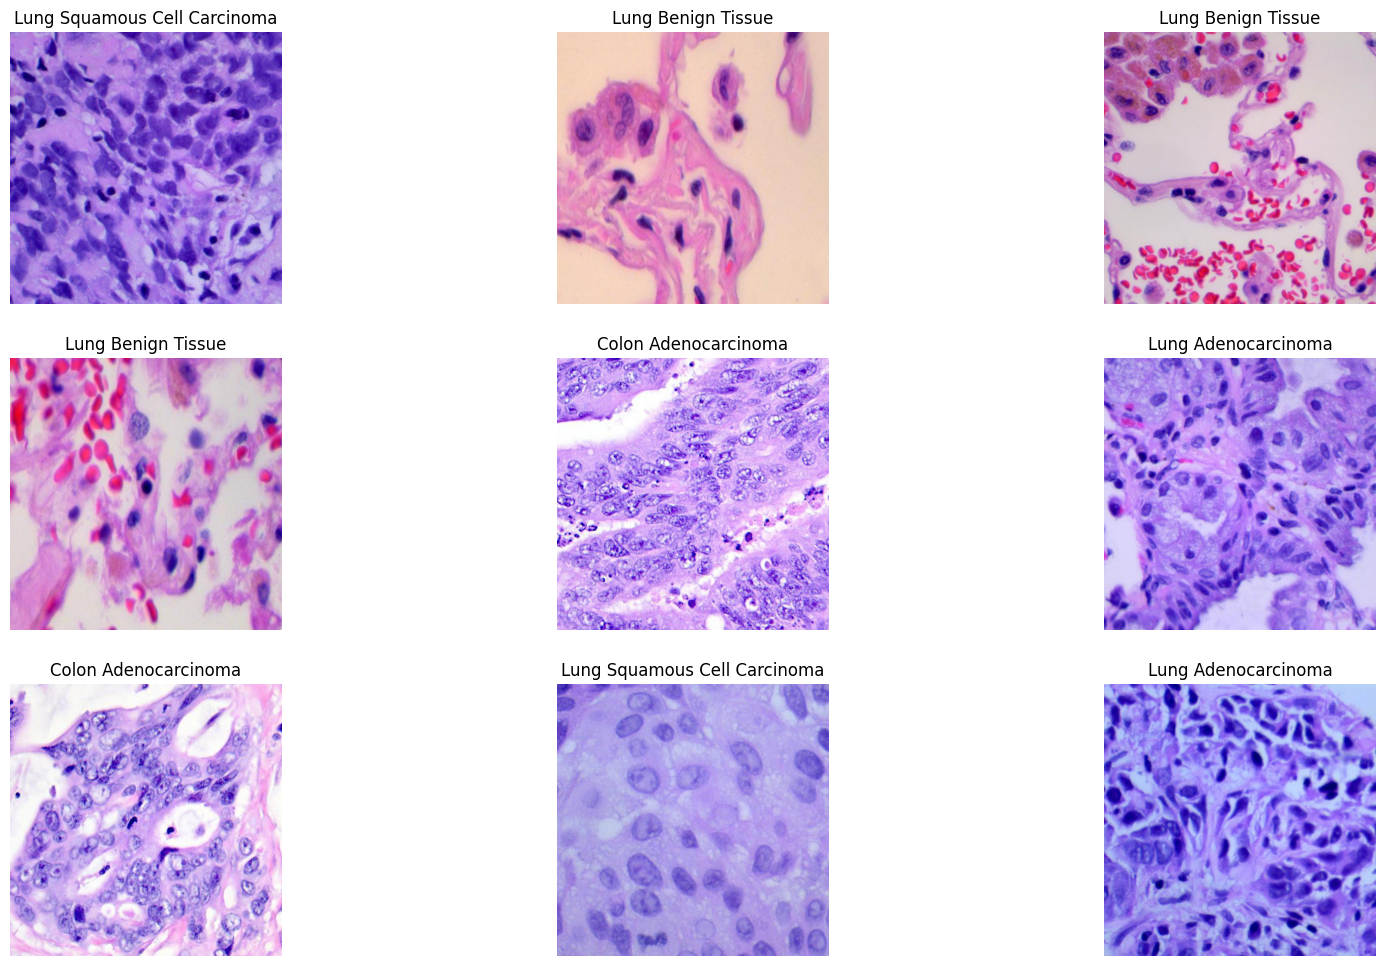

In [12]:
num_rows = 3
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(20,12))

for i in range(num_images):
    row_num = np.random.randint(0, data.shape[0])
    row = data.iloc[[row_num]]
    img = mpimg.imread(row['filepath'].item())

    plt.subplot(num_rows, num_cols, i + 1)
    plt.gca().set_title(row['label'].item())
    plt.gca().axis('off')
    plt.imshow(img)

plt.show()

Our next step is to split the dataset into three disjunct subsets: train set, test set, and validation set.

In [13]:
train_data, temp_data = train_test_split(data, train_size=0.7, shuffle=True, random_state=100)
validation_data, test_data = train_test_split(temp_data,  train_size=1/3, shuffle=True, random_state=100)

Once we have all the subsets, we need to create generators that will fetch minibatches, as well as do additional work such as data shuffling. We will set the minibatch size to 16. Of course, this hyperparameter can be changed at will.

In [14]:
batch_size = 16
image_size = (224, 224)
num_channels = 3

image_shape = (image_size[0], image_size[1], num_channels)
num_classes = 5

train_generator = ImageDataGenerator().flow_from_dataframe(train_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                           color_mode='rgb', shuffle=True, batch_size=batch_size)
validation_generator = ImageDataGenerator().flow_from_dataframe(validation_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                                color_mode='rgb', shuffle=False, batch_size=batch_size)
test_generator = ImageDataGenerator().flow_from_dataframe(test_data, x_col='filepath', y_col='label', target_size=image_size, class_mode='categorical', 
                                                          color_mode='rgb', shuffle=False, batch_size=batch_size)

classes = list(train_generator.class_indices.keys())

Found 17500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 5000 validated image filenames belonging to 5 classes.


Our next step is to choose the model. As our first model, we will choose the ResNet50 model pre-trained on the ImageNet dataset. We will adjust this model to our classification problem by adding a few fully connected layers, as well as a batch normalization and a dropout layer. The last fully connected layer will have 5 outputs, one for each class. Our model's prediction will then be equal to the index of the highest output value (we use softmax as the last layer's activation function).

In [15]:
def get_resnet_50():
    pretrained_model = ResNet50(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = False

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name='ResNet50')

    model.compile(Adam(learning_rate=0.00075), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

resnet50_model = get_resnet_50()
resnet50_model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                          

Finally, we can train our model by using the train and validation subsets. In order to do that, we need to determine the number of epochs. Additionally, we will define two callbacks: one for storing model weights and one for saving the train logs into a CSV file. Once the training is done, we will save our model's stats (such as accuracy, loss over the epochs, etc.) into an additional file.

In [16]:
def train_model(model, num_epochs=10):
    dirs = ['./models', './stats', './images']

    for dir in dirs:
        if not os.path.exists(f'{dir}/{model.name}'): 
            os.makedirs(f'{dir}/{model.name}')

    checkpoint_saver = ModelCheckpoint(
        filepath=f'./models/{model.name}/model',
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True,
    )

    log_saver = CSVLogger(f'./stats/{model.name}/logs.csv')

    stats = model.fit(x=train_generator, epochs=num_epochs, validation_data=validation_generator, verbose=1, callbacks=[checkpoint_saver, log_saver])

    with open(f'./stats/{model.name}/stats.txt', 'wb') as file:
        pickle.dump(stats.history, file)

Let's set the initial number of epochs to 60 and begin training our model.

In [9]:
num_epochs = 60
train_model(resnet50_model, num_epochs)

Epoch 1/60
1094/1094 [==============================] - 55s 45ms/step - loss: 0.8755 - accuracy: 0.9210 - val_loss: 0.1629 - val_accuracy: 0.9700
Epoch 2/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2503 - accuracy: 0.9557 - val_loss: 0.3458 - val_accuracy: 0.9600
Epoch 3/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2192 - accuracy: 0.9647 - val_loss: 0.0741 - val_accuracy: 0.9800
Epoch 4/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.2272 - accuracy: 0.9661 - val_loss: 0.1428 - val_accuracy: 0.9752
Epoch 5/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1883 - accuracy: 0.9710 - val_loss: 0.1017 - val_accuracy: 0.9816
Epoch 6/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1867 - accuracy: 0.9745 - val_loss: 0.1475 - val_accuracy: 0.9796
Epoch 7/60
1094/1094 [==============================] - 47s 43ms/step - loss: 0.1971 - accuracy: 0.9761 - val_loss: 0.1134 -

Once we've trained our model, we can use the saved statistics to graph the loss on different subsets over the epochs, as well as the model's accuracy. To do that, we will define two functions: one for graphing, and one for loading the stats.

In [19]:
def graph_accuracy_and_loss(stats, save_path=None):
    train_accuracy = stats.get('accuracy')
    validation_accuracy = stats.get('val_accuracy')

    train_loss = stats.get('loss')
    validation_loss = stats.get('val_loss')

    epochs = list(range(1, len(train_accuracy) + 1))

    plt.figure(figsize=(16,10))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_accuracy, c='blue', label='Train accuracy')
    plt.plot(epochs, validation_accuracy, c='orange', label='Validation accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_loss, c='blue', label='Train loss')
    plt.plot(epochs, validation_loss, c='orange', label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


def load_stats(model):
    with open(f'./stats/{model.name}/stats.txt', 'rb') as file:
        stats = pickle.load(file)   
    
    return stats

Now, we can fetch our model's stats and graph them.

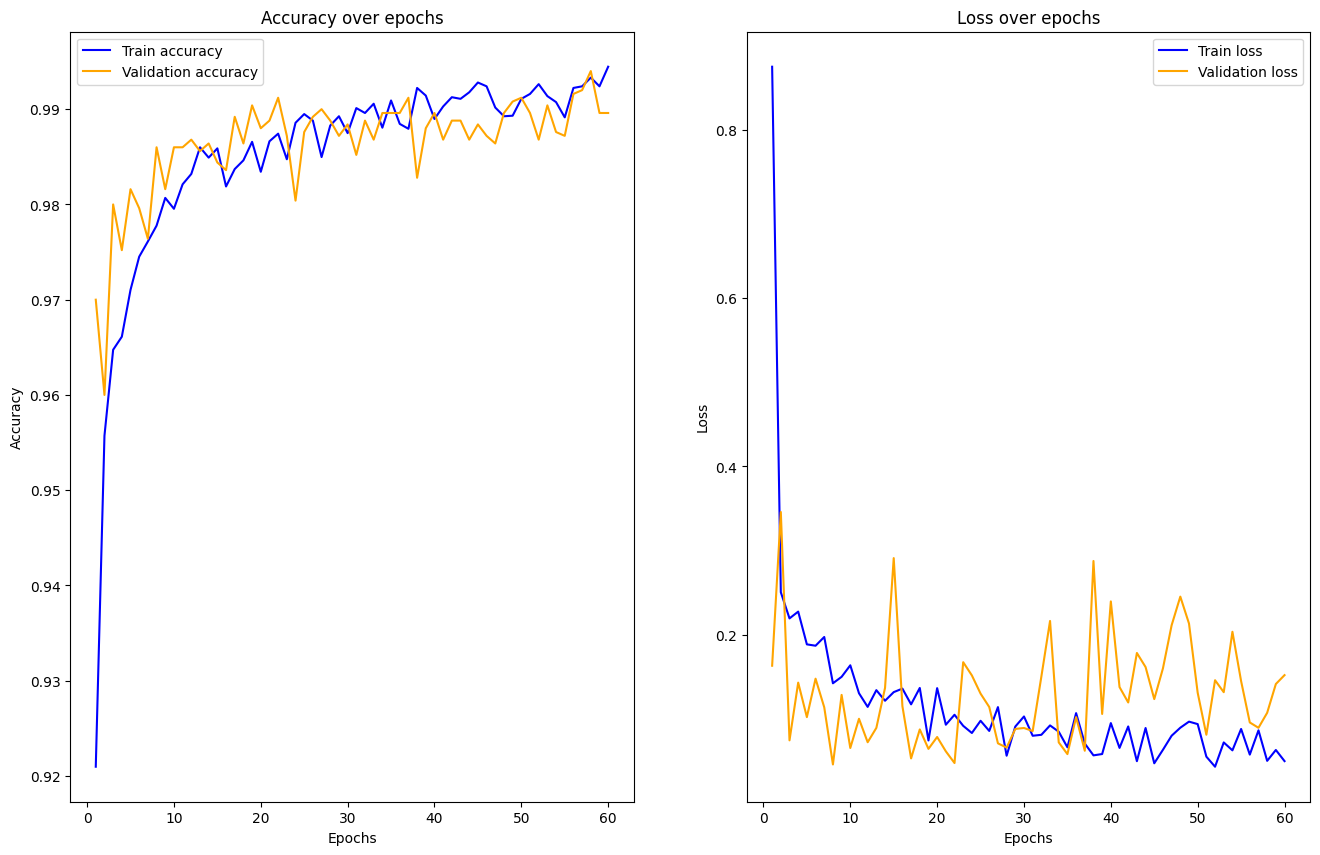

In [74]:
resnet50_stats = load_stats(resnet50_model)
graph_accuracy_and_loss(resnet50_stats, f'./images/{resnet50_model.name}/accuracy_loss.png')

Finally, we can test our model's performance on the test set.

In [28]:
def get_model_weights_path(model):
    return f'./models/{model.name}/model'


resnet50_model = get_resnet_50()
resnet50_model.load_weights(get_model_weights_path(resnet50_model))

results = resnet50_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 12s 36ms/step - loss: 0.0910 - accuracy: 0.9932


We will format these results and save them into the _stats_ directory.

In [29]:
def print_results(model, results):
    print(f'Model: {model.name}')
    print(f'Test accuracy: {results[1]}')
    print(f'Test loss: {results[0]}')

    with open(f'./stats/{model.name}/test_stats', 'w') as file:
        file.write(f'Test accuracy: {results[1]}\n')
        file.write(f'Test loss: {results[0]}')

print_results(resnet50_model, results)

Model: ResNet50
Test accuracy: 0.9932000041007996
Test loss: 0.09095156937837601


Once we've shown the model's accuracy and loss, we can also display a few additional fitness metrics, such as the confusion matrix, precision, recall, and F1 score. We will create a function to fetch the model's predictions for the test set.

In [30]:
def get_class_predictions(model):
    model_predictions = model.predict(test_generator)
    return np.argmax(model_predictions, axis=1)

Let's fetch the model's predictions for the test set.

In [31]:
resnet50_class_predictions = get_class_predictions(resnet50_model)

313/313 [==============================] - 11s 35ms/step


To visualize the confusion matrix, we will first create a function that calculates it and displays it in a nice format.

In [36]:
def show_confusion_matrix(class_predictions, save_path=None):
    confusiom_mat = confusion_matrix(test_generator.classes, class_predictions)

    plt.imshow(confusiom_mat, cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.colorbar()

    for i, val in enumerate(test_generator.class_indices.keys()):
        print(f"Class {i} is for {val}.")

    plt.xlabel('Real Label')
    plt.ylabel('Predicted Label')

    thresh = confusiom_mat.max() / 2.
    cm_color = lambda x: "white" if x > thresh else "black"
    for i, row in enumerate(confusiom_mat):    
        for j, col in enumerate(confusiom_mat[i]):
            percentage = round(confusiom_mat[i, j]/len(class_predictions) * 100, 2)
            text = f"{confusiom_mat[i, j]}\n{percentage}%"
            plt.text(j, i, text, horizontalalignment="center", verticalalignment="center", color=cm_color(confusiom_mat[i, j]))
            
    if save_path:
        plt.savefig(save_path)

    return confusiom_mat

Let's visualize the confusion matrix using our function.

Class 0 is for Colon Adenocarcinoma.
Class 1 is for Colon Benign Tissue.
Class 2 is for Lung Adenocarcinoma.
Class 3 is for Lung Benign Tissue.
Class 4 is for Lung Squamous Cell Carcinoma.


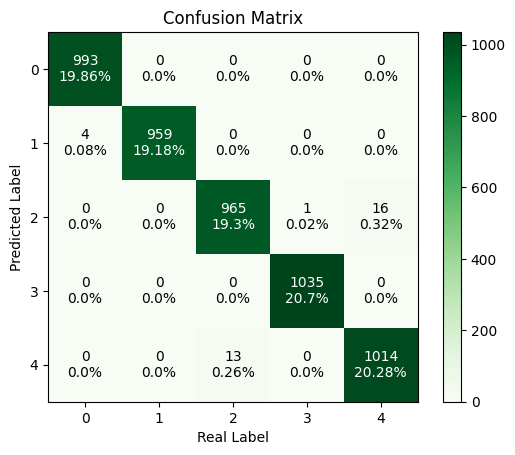

In [37]:
resnet50_conf_matrix = show_confusion_matrix(resnet50_class_predictions, f'./images/{resnet50_model.name}/confusion_matrix.png')

We will also define a function to plot the other various model performance metrics.

In [64]:
def show_performance_graphs(conf_matrix, save_path=None):
    N = np.sum(np.concatenate(conf_matrix))
    FP = np.sum(conf_matrix, axis=1)
    FN = np.sum(conf_matrix, axis=0)

    x = np.arange(len(classes) + 1)
    width = 0.13
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')

    accs = []
    precs = []
    F1s = []
    recs = []
    specs = []

    for i in range(len(conf_matrix)):
        TP_i = conf_matrix[i, i]
        FP_i = FP[i] - TP_i
        FN_i = FN[i] - TP_i
        TN_i = N - TP_i - FP_i - FN_i

        acc = (TP_i + TN_i) / (TN_i + TP_i + FN_i + FP_i) * 100
        prec = (TP_i) / (TP_i + FP_i) * 100
        F1 = (TP_i) / (TP_i + 0.5 * (FN_i + FP_i)) * 100
        rec = (TP_i) / (TP_i + FN_i) * 100
        spec = (TN_i) / (TN_i + FP_i) * 100

        accs.append(round(acc, 2))
        precs.append(round(prec,2))
        F1s.append(round(F1,2))
        recs.append(round(rec,2))
        specs.append(round(spec,2))

    measurements = {"Accuracy": accs, "Precision": precs, "F-1 Score": F1s, "Recall": recs, "Specificity": specs}
    colors = ["orange", "yellow", "green", "brown", "blue"]

    for i, item in enumerate(measurements.items()):
        key, val = item
        macro_value = (val[0] + val[1] + val[2] + val[3] + val[4]) / 5
        measurement = (val[0], val[1], val[2], val[3], val[4], round(macro_value,2))

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width=width-0.02, label=key, color=colors[i])
        ax.bar_label(rects, padding=3, rotation=45)
        multiplier += 1

    ax.set_title('Fitness metrics per class')
    ax.set_ylabel("Percentage (%) ")
    ax.set_xticks(x + width + 0.1, [*classes, "Macro"])
    ax.legend(loc='upper left', ncols=5)
    ax.set_ylim(95, 102)

    fig.set_figwidth(15)
    fig.set_figheight(5)
    
    if save_path:
        fig.savefig(save_path)

Let's visualize our model's performance.

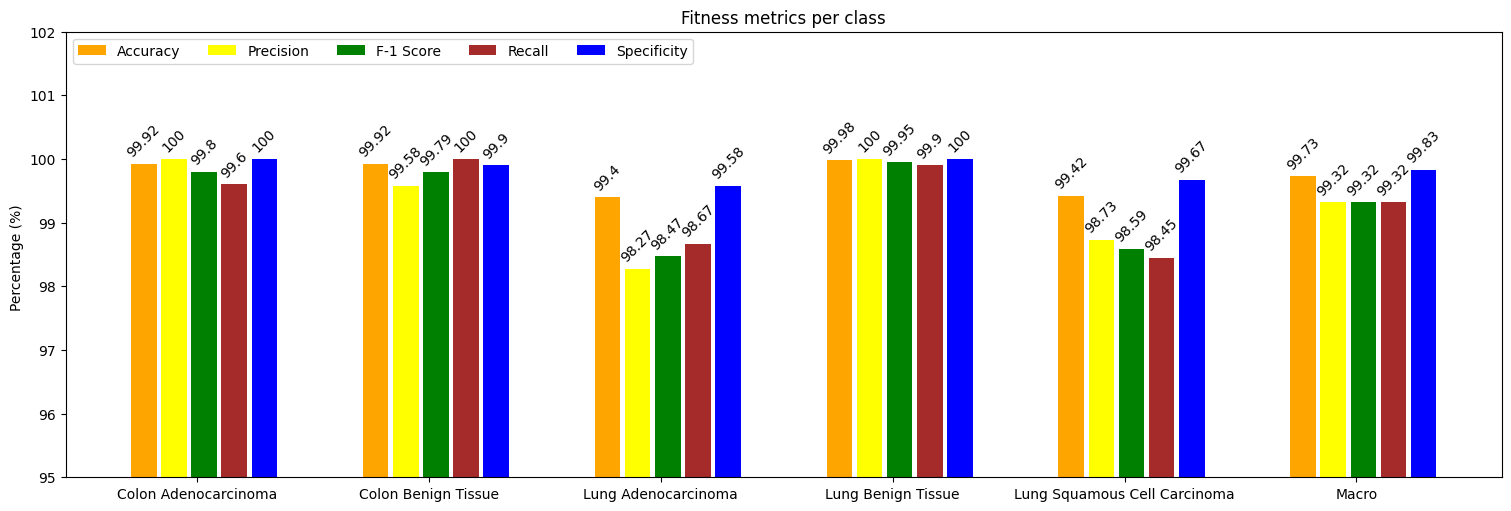

In [65]:
show_performance_graphs(resnet50_conf_matrix, f'./images/{resnet50_model.name}/fitness_metrics.png')

Besides ResNet50, there are many other architectures we could try out. One really interesting architecture is the MobileNetV2 model. This model works with significantly fewer parameters which makes it suitable for embedding in devices that don't have a lot of memory. To keep the total number of parameters low, we will only add one batch normalization layer, one flatten layer, and one fully connected layer with the softmax activation function.

In [66]:
def get_mobilenet_v2():
    pretrained_model = MobileNetV2(input_shape=image_shape, weights='imagenet', include_top=False)
    pretrained_model.trainable = True

    model = Sequential([
        pretrained_model,
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ], name='MobileNetV2')

    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

mobile_net_v2_model = get_mobilenet_v2()
mobile_net_v2_model.summary()

Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 1280)        5120      
 chNormalization)                                                
                                                                 
 flatten_5 (Flatten)         (None, 62720)             0         
                                                                 
 dense_10 (Dense)            (None, 5)                 313605    
                                                                 
Total params: 2576709 (9.83 MB)
Trainable params: 2540037 (9.69 MB)
Non-trainable params: 36672 (143.25 KB)
_________________________________________________________________


Let's train our MobileNetV2 model for 60 epochs.

In [21]:
num_epochs = 60
mobile_net_v2_model = get_mobilenet_v2()
train_model(mobile_net_v2_model, num_epochs)

Epoch 1/60
1094/1094 [==============================] - 68s 49ms/step - loss: 2.4953 - accuracy: 0.7905 - val_loss: 636.3812 - val_accuracy: 0.2108
Epoch 2/60
1094/1094 [==============================] - 50s 45ms/step - loss: 1.4989 - accuracy: 0.8698 - val_loss: 225.5470 - val_accuracy: 0.3756
Epoch 3/60
1094/1094 [==============================] - 49s 45ms/step - loss: 0.9320 - accuracy: 0.8986 - val_loss: 241.2691 - val_accuracy: 0.3252
Epoch 4/60
1094/1094 [==============================] - 50s 45ms/step - loss: 0.6311 - accuracy: 0.9186 - val_loss: 9.1263 - val_accuracy: 0.6376
Epoch 5/60
1094/1094 [==============================] - 50s 45ms/step - loss: 0.3333 - accuracy: 0.9350 - val_loss: 5.6505 - val_accuracy: 0.7088
Epoch 6/60
1094/1094 [==============================] - 50s 46ms/step - loss: 0.4062 - accuracy: 0.9251 - val_loss: 4.5791 - val_accuracy: 0.7428
Epoch 7/60
1094/1094 [==============================] - 51s 47ms/step - loss: 0.2651 - accuracy: 0.9407 - val_loss: 1.

Now, we can visualize the model's accuracy, as well as loss on the train and validation set over epochs.

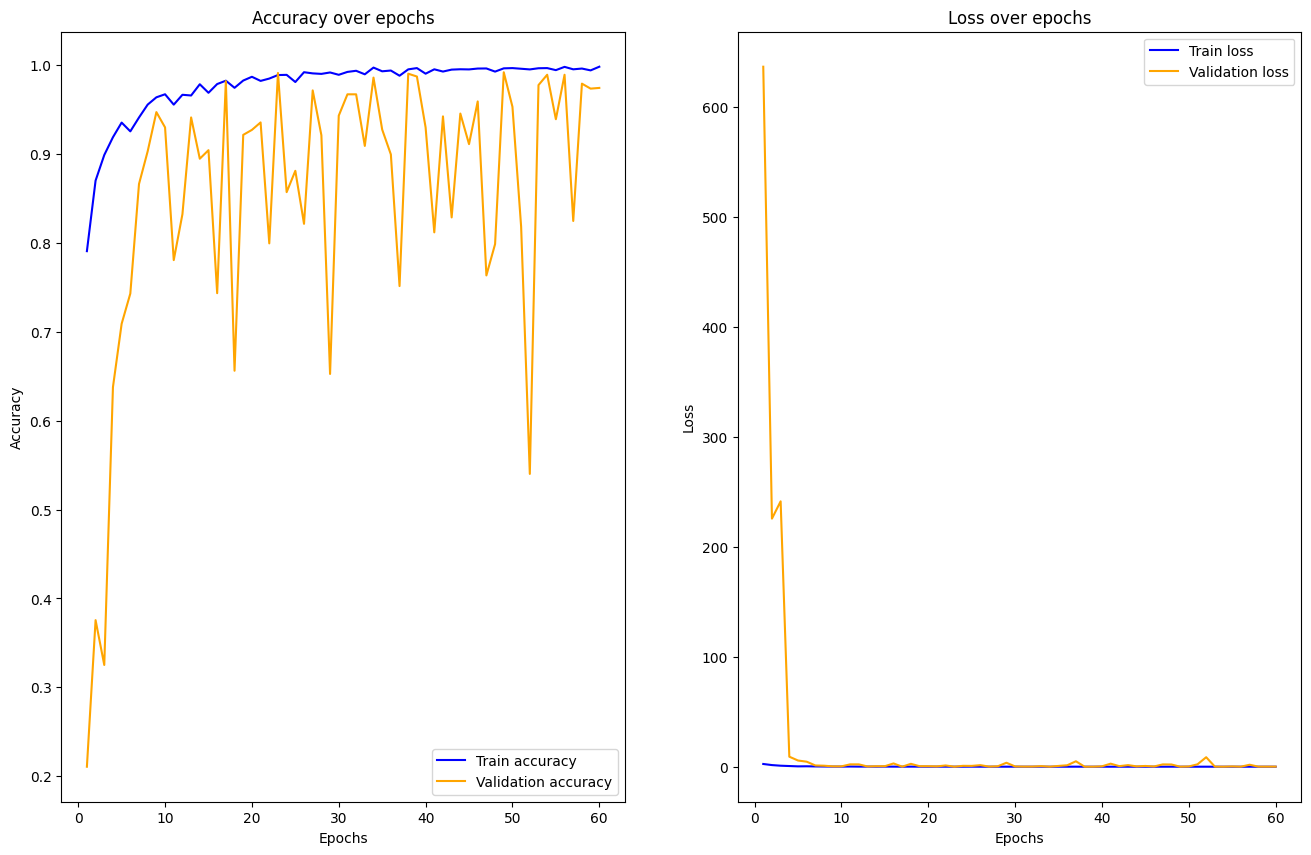

In [75]:
mobilenet_v2_stats = load_stats(mobile_net_v2_model)
graph_accuracy_and_loss(mobilenet_v2_stats, f'./images/{mobile_net_v2_model.name}/accuracy_loss.png')

Let's fetch our final MobileNetV2 model so that we can evaluate it on the test set.

In [68]:
mobilenet_v2_model = get_mobilenet_v2()
mobilenet_v2_model.load_weights(get_model_weights_path(mobilenet_v2_model))
mobilenet_results = mobilenet_v2_model.evaluate(test_generator, verbose=1)

313/313 [==============================] - 8s 23ms/step - loss: 0.0469 - accuracy: 0.9866


Now, we can save the model's performance on the test set.

In [69]:
print_results(mobile_net_v2_model, mobilenet_results)

Model: MobileNetV2
Test accuracy: 0.9865999817848206
Test loss: 0.04689840227365494


Of course, we can additionally display the confusion matrix, as well as other performance metrics for the model. We will start with fetching the model's predictions on the test set.

In [70]:
mobilenet_v2_class_predictions = get_class_predictions(mobilenet_v2_model)

313/313 [==============================] - 7s 22ms/step


Let's visualize the confusion matrix.

Class 0 is for Colon Adenocarcinoma.
Class 1 is for Colon Benign Tissue.
Class 2 is for Lung Adenocarcinoma.
Class 3 is for Lung Benign Tissue.
Class 4 is for Lung Squamous Cell Carcinoma.


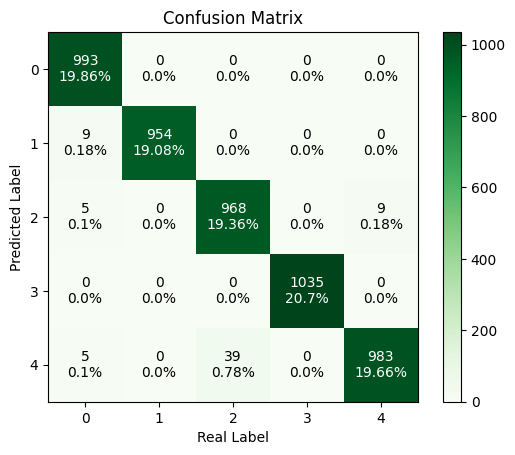

In [72]:
mobilenet_v2_conf_matrix = show_confusion_matrix(mobilenet_v2_class_predictions, f'./images/{mobilenet_v2_model.name}/confusion_matrix.png')

From the confusion matrix, we can see that the model has a bit of a problem with classifying images from the class "Lung Adenocarcinoma" - sometimes, it classifies the images as "Lung Squamous Cell Carcinoma". Additionally, we can visualize the other performance metrics.

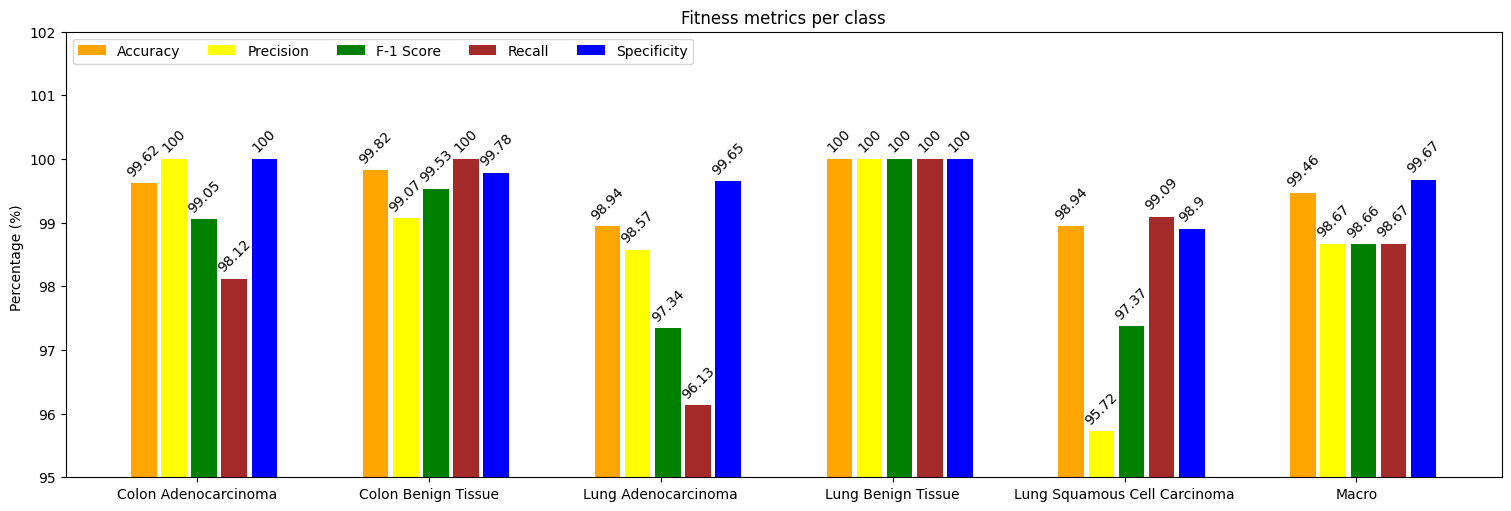

In [76]:
show_performance_graphs(mobilenet_v2_conf_matrix, f'./images/{mobilenet_v2_model.name}/fitness_metrics.png')